# Time Series Prediction


In [1]:
# @ Lukman copyright 
# MIT Licence

In [162]:
# for data frame analysis
import pandas as pd 

# for mathematical operations
import numpy as np 


# matplotlib library for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# For Normalizing data
from sklearn.preprocessing import StandardScaler

# For statistical test
import scipy.stats as stats

# Split data set into training and test set
from sklearn.model_selection import train_test_split as tts

# SVN module
from sklearn import svm

# Kernel Functions used 
from sklearn.metrics.pairwise import rbf_kernel,laplacian_kernel

# module for chi square test
from scipy.stats import chisquare


# For dictionary 
from collections import defaultdict

# for use of tensorflow
import tensorflow as tf
tf.enable_eager_execution()

#from tensorflow.nn.rnn import *
from tensorflow.python.ops  import *

# for scaling arrays
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler


# for random sampling of validation set
import random

import yaml
import os
from utility import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys

In [3]:
# enable eager executinon
tf.enable_eager_execution()

In [4]:
tf.__version__

'1.15.0'

In [102]:
# check GPU availability for tensorflow
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


# Data Preprocessing 

In [5]:
################################################################################
# load config file
try:
    with open("../config.yml", 'r') as ymlfile:
            cfg = yaml.safe_load(ymlfile)
except (IOError):
    print('config file is required. Put config file in current directory')
################################################################################

In [6]:
# # current working directory
# cwd = os.getcwd()
# # set the base directory. base directo
# BASE_DIR = os.path.join( os.path.dirname( cwd), '' )
# # cleaned data dir
# cleanedpath= BASE_DIR + cfg['cleanedconfig']['cleanedDataV1']['cleanedDir'] 
# # clean data Name
# cleandataName = cfg['cleanedconfig']['cleanedDataV1']['cleanedName']
# # traina and validation data name
# trainName= cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['tfcleanTrain']
# validateName  = cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['tfcleanValidate']
# validation_split = cfg['cleanedconfig']['cleanedDataV1']['validationSplit']

In [7]:
# current working directory
cwd = os.getcwd()
# set the base directory. base directo
BASE_DIR = os.path.join( os.path.dirname( cwd), '' )
# cleaned data dir
cleanedpath= BASE_DIR + cfg['cleanedconfig']['cleanedDataV2']['cleanedDir'] 
# clean data Name
cleandataName = cfg['cleanedconfig']['cleanedDataV2']['cleanedName']
# traina and validation data name
trainName= cfg['cleanedconfig']['cleanedDataV2']['TensorflowDataFlowConfig']['tfcleanTrain']

validateName  = cfg['cleanedconfig']['cleanedDataV2']['TensorflowDataFlowConfig']['tfcleanValidate']
validation_split = cfg['cleanedconfig']['cleanedDataV2']['validationSplit']

In [8]:
# boolean for preprocessing datasets for tensorflow
tfreprocess = cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['tfprocess']

In [9]:
if tfreprocess:
    
    _,_,data_types,col_names= utils.tfdatabuilder(cleanedpath,cleandataName,trainName, validateName,validation_split )
    
else:
    
    #train = pd.read_csv(cleanedpath + trainName) 
    #data_types,col_names = utils.tfpreprocess(train)
    data_types = [tf.float64, tf.float64, tf.float64, tf.float64, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32]
    col_names = ['meter_reading','square_feet','air_temperature','dew_temperature','month','day','hour','primary_use_Education',
             'primary_use_Entertainment/public assembly','primary_use_Food sales and service','primary_use_Healthcare',
             'primary_use_Lodging/residential','primary_use_Manufacturing/industrial','primary_use_Office','primary_use_Other',
             'primary_use_Parking','primary_use_Public services','primary_use_Religious worship','primary_use_Retail',
             'primary_use_Services','primary_use_Technology/science','primary_use_Utility','primary_use_Warehouse/storage',
             'site_id_0','site_id_1','site_id_2','site_id_3','site_id_4','site_id_5','site_id_6','site_id_7','site_id_8',
             'site_id_9','site_id_10','site_id_11','site_id_12','site_id_13','site_id_14','site_id_15']

#### Work with downloaded csv to preserve data type
Load the csv file and parse the data types of the datatset together into the
tensorflow load pipeline

In [14]:
# load the data using the tensorflow Dataset API
# add the data types too
csvData = tf.data.experimental.CsvDataset(cleanedpath + trainName, data_types, header=True)
# validation data
validateData = tf.data.experimental.CsvDataset(cleanedpath + validateName, data_types, header=True)

In [11]:
# categorical features to use 
catfeatures = cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['categoricalFeatureToUse']
catNames = cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['CategoricalFeature']

#### Parse data 

In [12]:
# Parsing the data and
# merging the columns:
# ---- day and month as single column
# ---- merge the site id as a single feature vector vector
# ---- primary use as a single feature vector

# take the forst 4 col names that meter reading, square feet, air temp , dew temp,
# add it to a the new column names that would be formed after single column merging

#categorical feature selection
# here one can decide if to use site id or not . Site id is index 2 from catnames
if catfeatures == 3:
    col_names_= [col_names[0],col_names[1],col_names[2],col_names[3],catNames[0],catNames[1],catNames[2] ]
else:
    col_names_= [col_names[0],col_names[1],col_names[2],col_names[3],catNames[0],catNames[1]]

def _parse_csv_row(*vals):
    '''
    Uses Feature columns
    Does feature engineering
    '''
    
    # month and day and single feature
    month_day = tf.convert_to_tensor(vals[4:7])
    # primary use as single feature
    primary_use = tf.convert_to_tensor(vals[7:23]) # this index can be chage but ensure consistency 
    if catfeatures == 3:
        # site id as single feature
        site_id =  tf.convert_to_tensor(vals[23:39])
    
        # merge the features together, note meter reading is the fist column
        # so it is excluded -- meaning index starts from 1
        feature_vals = vals[1:4] + (month_day,primary_use,site_id)
    else:
        feature_vals = vals[1:4] + (month_day,primary_use)
        
    
    
    # zip into a  feature sets into a single col
    features = dict(zip(col_names_[1:],feature_vals))
    
    # name the targets or lables
    targets_tensor = tf.convert_to_tensor(vals[0],name=col_names_[0]) 
    
    
    
    return features, targets_tensor

##### Batch the datatset

In [12]:
# this is needed for testing
dataset = csvData.map(_parse_csv_row).batch(64)

In [15]:
### validation set 
validateset = validateData.map(_parse_csv_row).batch(64)
#print(list(dataset.take(1)))

##### Feature Categorization

In [31]:
primary_use = tf.feature_column.numeric_column(catNames[1], shape=(16,))
site_id = tf.feature_column.numeric_column(catNames[2], shape=(16,))
month_day = tf.feature_column.numeric_column(catNames[0], shape=(3,))

In [32]:
# ormalizer
normalizer = lambda x: tf.math.divide(tf.math.subtract(x, tf.reduce_mean(x)), tf.math.reduce_std(x)+1e-8)

In [33]:
numeric_columns = [tf.feature_column.numeric_column(feat,normalizer_fn=normalizer) for feat in col_names_[1:4]]

In [34]:
#columns = numeric_columns + [month_day,primary_use,site_id]

In [35]:
#feature_layer = tf.keras.layers.DenseFeatures(columns)

In [36]:
# function to serve the data set 
def load_data(*filename,fn = _parse_csv_row,training=True):
    Training = training
    batchsize = 64
    csvData = tf.data.experimental.CsvDataset(filename, data_types, header=True)
    dataset= csvData.map(fn)
    if Training:
        dataset = dataset.shuffle(1000).repeat()
    return dataset.batch(batchsize)
    
    

# Build Model

In [96]:
from tensorflow.keras import backend as K

def root_mean_squared_error():
    '''
    
    this is the loss function specified in kaggle competition
    '''
        
    return K.sqrt(K.mean (K.square( (K.log(K.abs(y_pred)+1) - K.log(y_true+1))   )   )   )



def root_mean_squared_error2():
    '''
    this is 1.- mean squared
    root mean squared is a value between 0 and 1 
    to reflect accuracy use 1-rms
    '''
        
    return  K.sqrt(K.mean( ( K.square ( y_pred - y_true    )   )   )) 

In [214]:
# wide and deep model 
# https://arxiv.org/pdf/1606.07792.pdf
model = tf.estimator.DNNLinearCombinedRegressor(
          # wide settings
         linear_feature_columns=[month_day, primary_use,site_id,numeric_columns[0],numeric_columns[1],numeric_columns[2] ],
         linear_optimizer=tf.train.FtrlOptimizer(1e-3,l2_regularization_strength=1e-4 ),
         # deep settings
         dnn_feature_columns=[
         month_day, primary_use,numeric_columns[0],numeric_columns[1],numeric_columns[2]],
        dnn_hidden_units=[400, 200, 50],
        dnn_dropout=0.5,
        dnn_optimizer=tf.train.ProximalAdagradOptimizer(1e-3,l2_regularization_strength=1e-4)
      )


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp1gg56kc4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdf9429bd90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [205]:
# add the metrics to use in the computation
#model = tf.contrib.estimator.add_metrics(model, root_mean_squared_error)

In [215]:
train_spec = tf.estimator.TrainSpec(input_fn=lambda : load_data(cleanedpath + trainName),  max_steps=40000)
eval_spec = tf.estimator.EvalSpec(input_fn=lambda : load_data(cleanedpath + validateName))

#tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

In [216]:
# run training

for i in range(3):
    tf.estimator.train_and_evaluate(model, train_spec, eval_spec)

INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp1gg56kc4/model.ckpt.
INFO:tensorflow:loss = 3033212.0, step = 1
INFO:tensorflow:global_step/sec: 95.8133
INFO:tensorflow:loss = 22308896.0, step = 101 (1.045 sec)
INFO:tensorflow:global_step/sec: 105.619
INFO:tensorflow:loss = 7667697.0, step = 201 (0.947 sec)
INFO:tensorflow:global_step/sec: 108.355
INFO:tensorflow:loss = 1077479.6, step = 301 (0.923 sec)
INFO:t

INFO:tensorflow:global_step/sec: 111.419
INFO:tensorflow:loss = 937148.75, step = 7701 (0.898 sec)
INFO:tensorflow:global_step/sec: 113.346
INFO:tensorflow:loss = 7277496.0, step = 7801 (0.882 sec)
INFO:tensorflow:global_step/sec: 106.101
INFO:tensorflow:loss = 22153230.0, step = 7901 (0.942 sec)
INFO:tensorflow:global_step/sec: 111.002
INFO:tensorflow:loss = 7283780.0, step = 8001 (0.901 sec)
INFO:tensorflow:global_step/sec: 110.747
INFO:tensorflow:loss = 14683226.0, step = 8101 (0.903 sec)
INFO:tensorflow:global_step/sec: 109.931
INFO:tensorflow:loss = 1339777.2, step = 8201 (0.910 sec)
INFO:tensorflow:global_step/sec: 109.735
INFO:tensorflow:loss = 3565845.0, step = 8301 (0.911 sec)
INFO:tensorflow:global_step/sec: 110.351
INFO:tensorflow:loss = 3011749.2, step = 8401 (0.907 sec)
INFO:tensorflow:global_step/sec: 111.905
INFO:tensorflow:loss = 2549790.0, step = 8501 (0.893 sec)
INFO:tensorflow:global_step/sec: 109.045
INFO:tensorflow:loss = 11706176.0, step = 8601 (0.917 sec)
INFO:te

INFO:tensorflow:loss = 4464673.0, step = 15901 (0.953 sec)
INFO:tensorflow:global_step/sec: 104.278
INFO:tensorflow:loss = 1367705.2, step = 16001 (0.959 sec)
INFO:tensorflow:global_step/sec: 105.284
INFO:tensorflow:loss = 2285866.2, step = 16101 (0.950 sec)
INFO:tensorflow:global_step/sec: 104.375
INFO:tensorflow:loss = 3419547.8, step = 16201 (0.958 sec)
INFO:tensorflow:global_step/sec: 105.246
INFO:tensorflow:loss = 2237272.0, step = 16301 (0.950 sec)
INFO:tensorflow:global_step/sec: 106.072
INFO:tensorflow:loss = 1083526.8, step = 16401 (0.943 sec)
INFO:tensorflow:global_step/sec: 104.25
INFO:tensorflow:loss = 1689535.4, step = 16501 (0.959 sec)
INFO:tensorflow:global_step/sec: 105.118
INFO:tensorflow:loss = 2195916.0, step = 16601 (0.952 sec)
INFO:tensorflow:global_step/sec: 110.162
INFO:tensorflow:loss = 51946060.0, step = 16701 (0.908 sec)
INFO:tensorflow:global_step/sec: 105.694
INFO:tensorflow:loss = 3062374.5, step = 16801 (0.946 sec)
INFO:tensorflow:global_step/sec: 107.187


INFO:tensorflow:loss = 4600347.0, step = 24101 (0.873 sec)
INFO:tensorflow:global_step/sec: 113.583
INFO:tensorflow:loss = 1031167.56, step = 24201 (0.881 sec)
INFO:tensorflow:global_step/sec: 113.361
INFO:tensorflow:loss = 3205987.0, step = 24301 (0.882 sec)
INFO:tensorflow:global_step/sec: 109.067
INFO:tensorflow:loss = 4195707.0, step = 24401 (0.917 sec)
INFO:tensorflow:global_step/sec: 109.947
INFO:tensorflow:loss = 965547.75, step = 24501 (0.909 sec)
INFO:tensorflow:global_step/sec: 109.042
INFO:tensorflow:loss = 2732578.0, step = 24601 (0.917 sec)
INFO:tensorflow:global_step/sec: 111.206
INFO:tensorflow:loss = 1593660.8, step = 24701 (0.899 sec)
INFO:tensorflow:global_step/sec: 108.544
INFO:tensorflow:loss = 1952443.0, step = 24801 (0.922 sec)
INFO:tensorflow:global_step/sec: 111.685
INFO:tensorflow:loss = 2167491.2, step = 24901 (0.896 sec)
INFO:tensorflow:global_step/sec: 106.853
INFO:tensorflow:loss = 5865116.0, step = 25001 (0.935 sec)
INFO:tensorflow:global_step/sec: 107.317

INFO:tensorflow:loss = 2587582.5, step = 32301 (0.932 sec)
INFO:tensorflow:global_step/sec: 109.412
INFO:tensorflow:loss = 1748262.0, step = 32401 (0.915 sec)
INFO:tensorflow:global_step/sec: 108.058
INFO:tensorflow:loss = 2019597.0, step = 32501 (0.924 sec)
INFO:tensorflow:global_step/sec: 108.937
INFO:tensorflow:loss = 5587699.0, step = 32601 (0.918 sec)
INFO:tensorflow:global_step/sec: 109.847
INFO:tensorflow:loss = 5255765.0, step = 32701 (0.910 sec)
INFO:tensorflow:global_step/sec: 109.571
INFO:tensorflow:loss = 2358197.5, step = 32801 (0.913 sec)
INFO:tensorflow:global_step/sec: 107.059
INFO:tensorflow:loss = 1632177.5, step = 32901 (0.934 sec)
INFO:tensorflow:global_step/sec: 113.205
INFO:tensorflow:loss = 3853998.5, step = 33001 (0.883 sec)
INFO:tensorflow:global_step/sec: 108.524
INFO:tensorflow:loss = 1447120.8, step = 33101 (0.921 sec)
INFO:tensorflow:global_step/sec: 111.971
INFO:tensorflow:loss = 2508008.0, step = 33201 (0.893 sec)
INFO:tensorflow:global_step/sec: 110.649


INFO:tensorflow:Evaluation [50/100]
INFO:tensorflow:Evaluation [60/100]
INFO:tensorflow:Evaluation [70/100]
INFO:tensorflow:Evaluation [80/100]
INFO:tensorflow:Evaluation [90/100]
INFO:tensorflow:Evaluation [100/100]
INFO:tensorflow:Finished evaluation at 2020-01-26-13:08:21
INFO:tensorflow:Saving dict for global step 40000: average_loss = 66774.16, global_step = 40000, label/mean = 144.4864, loss = 4273546.0, prediction/mean = 235.71756
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 40000: /tmp/tmp1gg56kc4/model.ckpt-40000
INFO:tensorflow:Loss for final step: 31374968.0.
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Skipping training since max_steps has alrea

## Testing


In [217]:
def _parse_csv_row2(*vals):
    '''
    Uses Feature columns
    Does feature engineering
    '''
    
    # month and day and single feature
    month_day = tf.convert_to_tensor(vals[4:7])
    # primary use as single feature
    primary_use = tf.convert_to_tensor(vals[7:23])
    # site id as single feature
    site_id =  tf.convert_to_tensor(vals[23:39])
    
    # merge the features together, note meter reading is the fist column
    # so it is excluded -- meaning index starts from 1
    feature_vals = vals[1:4] + (month_day,primary_use,site_id)
    
    
    # zip into a  feature sets into a single col
    features = dict(zip(col_names_[1:],feature_vals))
    
    # name the targets or lables
    targets_tensor = tf.convert_to_tensor(vals[0],name=col_names_[0]) 
    
    
    
    return features

In [218]:
# test data path
testpath= BASE_DIR + cfg['cleanedtest']['TargetDir']
testDataName= cfg['cleanedtest']['testFeatureSet']
testName = cfg['cleanedtest']['testData']
testzero =  cfg['cleanedtest']['testDatasetName']

In [219]:
# read test data
if tfreprocess:
    
    data_types, col_names = utils.tfdatabuilder(testpath,testDataName,testName, validateName,validation_split,test=True )
    
else:
    pass
    #test = pd.read_csv(testpath + testName) 

In [220]:
local_learn = True

In [118]:
# execute this once , LLOCAL learn variable ensure it does not execute 2ce to save time
# set local_learn in cell above to true to run again
# increase testpoints to collect more datapoints
if local_learn:
    testpoints = 10000
    prototype_data = pd.read_csv(testpath + testName,nrows=testpoints)
    prototype_data.to_csv('prototype_data.csv',index=None)
else:
    local_learn = False

In [119]:
# function to serve the data set 
def load_data2(*filename,fn = _parse_csv_row2):
    batchsize = 64
    csvData = tf.data.experimental.CsvDataset(filename, data_types, header=True)
    dataset= csvData.map(fn)
    return dataset.batch(batchsize)
    
    

In [120]:
    #model.train(input_fn=lambda : load_data('meter1.csv'), steps=100)

In [223]:
predictions = model.predict(input_fn=lambda : load_data2('prototype_data.csv'))

In [224]:
results   = list(predictions);
#tf.logging.info(results)
#results

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp1gg56kc4/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [225]:
# get predicted values from list
predictions = []
for i in results:
    predictions.append( i['predictions'])



In [212]:
# upload true meter reADINGS
#true_readings = pd.read_csv(testpath + testzero) 
true_readings = pd.read_csv(testpath + testzero,nrows=testpoints) 


del true_readings['Unnamed: 0']

Text(0.5, 0, 'Iterations')

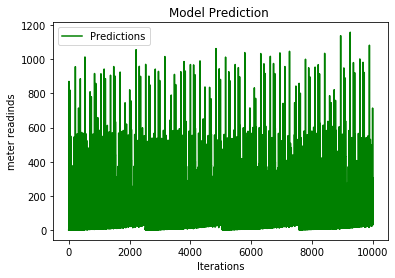

In [226]:
plt.plot(predictions,"-g" ,label='Predictions')
#plt.plot(true_values, "-r",label='True Values')
plt.legend(loc="upper left")
plt.title('Model Prediction ')
plt.ylabel('meter readinds')
plt.xlabel('Iterations')

Text(0.5, 0, 'Iterations')

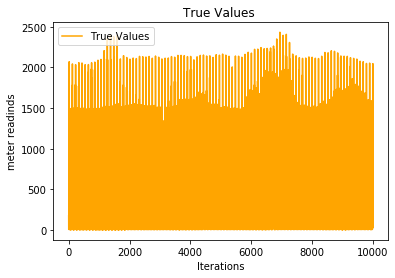

In [132]:
#plt.plot(predictions,"-g" ,label='Predictions')
plt.plot(true_readings.meter_reading, "-r",label='True Values',color='orange')
plt.legend(loc="upper left")
plt.title('True Values ')
plt.ylabel('meter readinds')
plt.xlabel('Iterations')

#### Plot per Building

In [202]:
test_predicted = pd.DataFrame(list(zip(list(true_readings.building_id),list(true_readings.timestamp),list(predictions))),columns= ['building_id','timestamp', 'meter_reading' ] )

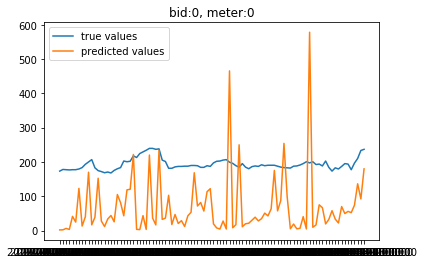

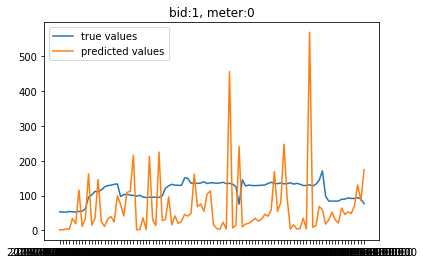

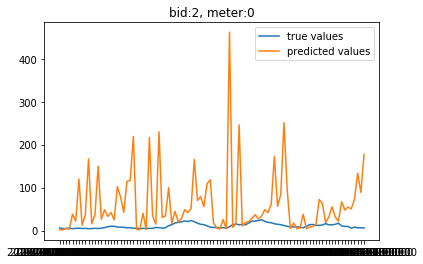

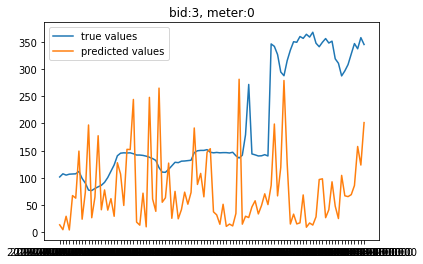

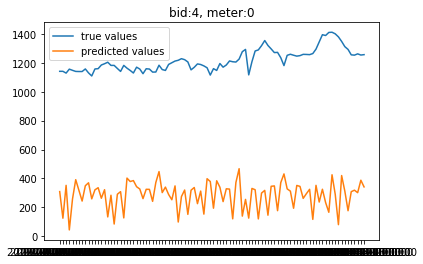

In [203]:
utils.plot_meter(true_readings,test_predicted,bn=5)

# save model

In [27]:
checkpoint_path = cfg['savedModel']['myname']['Dir3']

In [28]:
featuresample = list(dataset.take(1))[0][0]

In [29]:
# input function
inut_receive_fn = tf.estimator.export.build_raw_serving_input_receiver_fn(featuresample)

In [30]:
model.export_saved_model(export_dir_base=checkpoint_path ,serving_input_receiver_fn=inut_receive_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Signatures EXCLUDED from export because they cannot be be served via TensorFlow Serving APIs:
INFO:tensorflow:'serving_default' : Regression input must be a single string Tensor; got {'square_feet': <tf.Tensor 'Placeholder:0' shape=(?,) dtype=int32>, 'air_temperature': <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype

b'savedModels/CombinedLinear/1579537992'